# Reverse Process

## Imports

In [1]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from cv2 import cvtColor, COLOR_BGR2RGB, COLOR_LAB2RGB, COLOR_LAB2BGR
import sys
from einops import rearrange

sys.path.append('../')
#from util import LABtoRGB
from scripts import customUNet as unet
from scripts import forward_process as fp, reverse_process as rp, train, util

## Load image from dataset

In [2]:
ab1 = np.load("../data/image-colorization/ab/ab/ab1.npy")
ab2 = np.load("../data/image-colorization/ab/ab/ab2.npy")
ab3 = np.load("../data/image-colorization/ab/ab/ab3.npy")
l = np.load("../data/image-colorization/l/gray_scale.npy")
# Concatenate the numpy files
ab = np.concatenate((ab1,ab2,ab3),axis=0)

In [3]:
lab = np.zeros((1,224,224,3))
img_index= 5000 # not used during training
lab[:,:,:,0] = l[img_index,:]
lab[:,:,:,1:] = ab[img_index,:]    

lab = lab[0].astype("uint8")
lab.shape

(224, 224, 3)

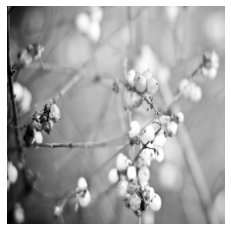

In [4]:
plt.axis('off')
plt.imshow(lab[:,:,0], cmap='gray')

In [5]:
# Load the color LAB image
size=64
img = cv2.normalize(lab, None, alpha = -1, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img = cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)

img = torch.tensor(np.array(img))
# Reshape so the tensor has the right shape for training
img = rearrange(img,"h w c-> 1 c h w")
img.shape

torch.Size([1, 3, 64, 64])

In [6]:
# Take the L part of the LAB image to have grayscale
gray = img[:,0,:,:]
gray = rearrange(gray,"b w h-> b w h 1")
gray = gray.expand(gray.shape[0],gray.shape[1],gray.shape[2],3)
gray = rearrange(gray,"b w h c-> b c w h")
gray.shape

torch.Size([1, 3, 64, 64])

## Load model

In [7]:
T = 300
diffTerms = util.ConstantDiffusionTerms(T, fp.linear_beta_schedule)
model = unet.CustomConditionalUNet()
model.load_state_dict(torch.load("../models/modelv1.pth"))
device = util.set_device()
model.to(device);

## Sample

In [8]:
noisy_images = rp.p_sample_loop(model,gray.shape,device,T,gray,diffTerms)

299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
saving!
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
saving!
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
saving!
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
saving!
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
saving!
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
saving!
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
saving!
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
saving!
59
58
57
56
55
5

In [9]:
len(noisy_images)

10

In [10]:
results = []
for img in noisy_images:
    img = rearrange(img,"b c w h-> b w h c")[0]
    norm = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm = norm.astype("uint8")
    img_rgb = cv2.cvtColor(norm,cv2.COLOR_LAB2RGB)
    results.append(img_rgb)

X_0 is the last element displayed


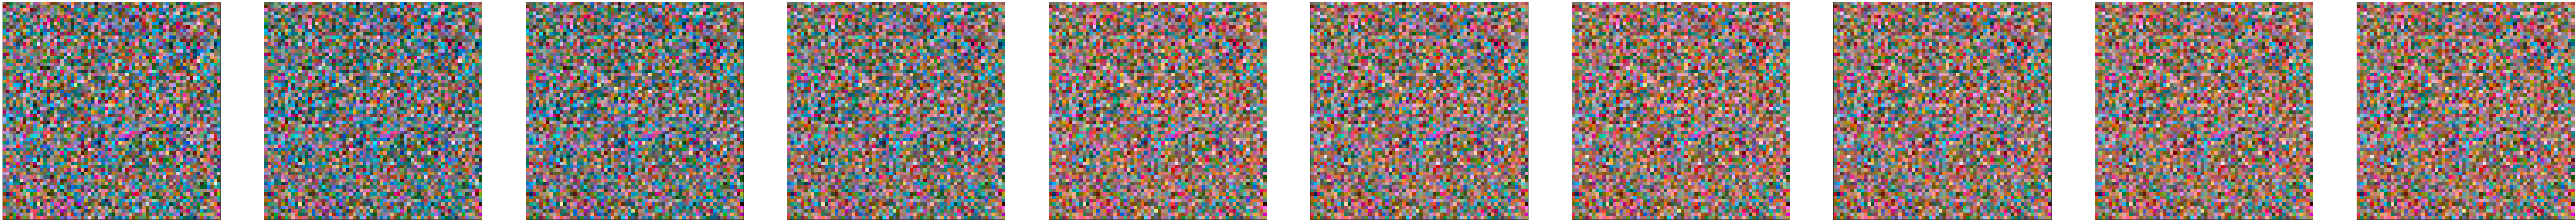

In [11]:
if not isinstance(results[0], list):
    results = [results]

num_rows = len(results)
num_cols = len(results[0])
fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)

for row_idx, row in enumerate(results):
    row = row
    for col_idx, img in enumerate(row):
        ax = axs[row_idx, col_idx]
        ax.imshow(np.asarray(img))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
print("X_0 is the last element displayed")

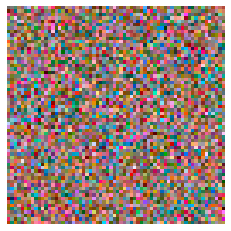

In [12]:
plt.axis('off')
plt.imshow(np.asarray(results[0][-1]))